In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import PyCrystalField as cef
import scipy
from scipy.misc import derivative
import lmfit
import pandas as pd
from numba import njit

 *******************************************************
 *                PyCrystalField 2.3.9                 *
 *  Please cite  J. Appl. Cryst. (2021). 54, 356-362   * 
 *    <https://doi.org/10.1107/S160057672001554X>      *
 *******************************************************



In [145]:
import lmfit

In [159]:
temperature = 2 # in K

muB = 5.7883818012e-2  # meV/T
mu0 = np.pi*4e-7       # T*m/A
kB  = 8.617e-2         # [meV/K]
meVToCm =meVTocCmInv= 8.066 
ion = 'Er3+'

kBT = kB*temperature

Jperp = -0.2#e-3 #meV
Jz = -2.5#e-3 #meV
q= 6

In [160]:
# my fit vals
# B20 = -0.03553308
# B40 = -3.7973e-04
# B43 = -0.01424079
# B60 =  3.0728e-06
# B63 = -2.7710e-07
# B66 =  3.8956e-05 

B20 = -0.03265325 # init = -0.03559)
B40 = -0.0003849 # fixed)
B43 = -0.01393 # fixed)
B60 =  3.054e-06 # fixed)
B63 = -8.4011e-07 # init = -4.695e-06)
B66 =  3.3815e-05 # fixed)

g = cef.LandeGFactor(ion)
myBparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
MyErObj = cef.CFLevels.Bdict(ion,myBparams)


# neutron fit vals
B20 = -4.73e-2
B40 = -3.7037e-4
B43 = -1.44431e-2
B60 = 3.1605e-6
B63 = 6.5259e-6
B66 = 3.9314e-5

g = cef.LandeGFactor(ion)
AllenBparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
AllenErObj = cef.CFLevels.Bdict(ion,AllenBparams)

# okay, so now we rebuild with pcf built ins

In [200]:
#first do me

field = [[0,0,b] for b in np.linspace(-10,10,10000)]
magMe_C = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T

# then do the neutron fit vals
field = [[0,0,b] for b in np.linspace(-10,10,1000)]
magAllen_C = np.array([AllenErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T


Text(0, 0.5, 'mag')

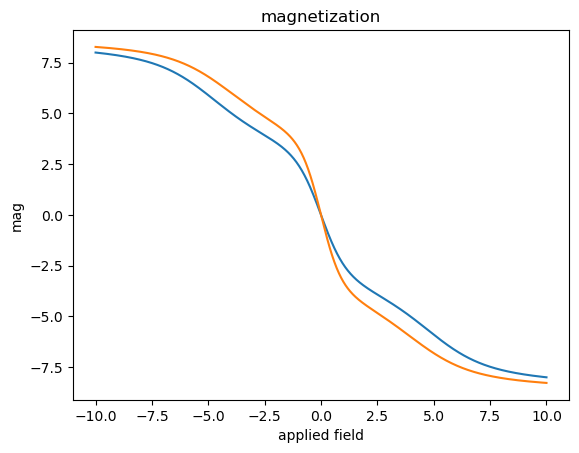

In [162]:
plt.plot(field[2], magMe_C[2])
plt.plot(field[2], magAllen_C[2])
plt.title('magnetization')
plt.xlabel('applied field')
plt.ylabel('mag')

# now we do MFT
this is following the code allen sent

Text(0, 0.5, 'magnetization')

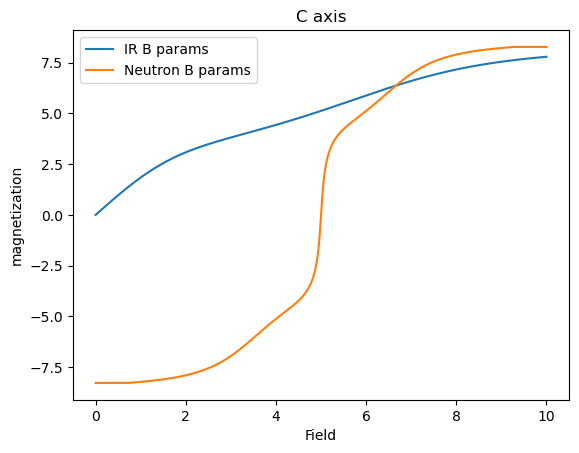

In [207]:
# f= field[2]
field = [[0,0,b] for b in np.linspace(0,10,10000)]
magMe_C = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T

mme_C = magMe_C[2]
f = np.linspace(0,10,1000)
ffine = np.linspace(0,10,len(mme_C))

gJ = cef.LandeGFactor('Er3+')
# print(gJ)
# @njit

Jperp = -0.2e-3 #meV
Jz = -2.4e-3 #meV
q= 6

def MolecularFieldTheory(H, Hth, Mth, lamb):
    '''Use mean field theory to correct magnetization
    for an exchange strength lamb. H is the number of fields to calculate,
    Hth and Mth are the theoretical single-ion magnetization curves to correct.'''
    n = 10
    # colors = plt.cm.gnuplot(np.linspace(0,1,n))
    # plt.figure()
    # plt.plot(Hth, Mth, 'r', label = 'orginal data')
    newM = np.interp(H, Hth, Mth)
    for i in range(n):
        newH = H - 6*lamb*newM/muB/(gJ)**2
        newM = np.interp(newH,Hth,Mth)
        # for testing
    #     plt.plot(newH, newM, label = str(i), color = colors[i])
    # plt.legend()
    return newM
 

# test = MolecularFieldTheory(np.array([1,4]), np.array([3,5]), np.array([3,5]), 0.1)

# define lamb for CES
lambAB = Jperp
lambC = Jz
 
maxi = 10
mme_C = magMe_C[2]

mft_mZ_me_C = MolecularFieldTheory(f, ffine, mme_C, lambC)
# mft_mZ_Allen_C = MolecularFieldTheory(f, ffine, mAllen_C, lambC)

plt.plot(f, -1*mft_mZ_me_C, label = 'IR B params')
plt.plot(f, -1*mft_mZ_Allen_C, label = 'Neutron B params')
# plt.xlim(0,10)
# plt.ylim(0,9)
plt.legend()
plt.title('C axis')
plt.xlabel('Field')
plt.ylabel('magnetization')

# now lets llook at AB plane :(

In [208]:

# field = [[b,0,0] for b in np.linspace(-10,10,1000)]
magMe = np.array([MyErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T



# field = [[b,0,0] for b in np.linspace(-10,10,1000)]
magAllen = np.array([AllenErObj.magnetization(ion, temperature, f) for f in field]).T
field = np.array(field).T

mme = magMe[0]
mAllen = magAllen[0]


Jperp = -0.2e-3 #meV
Jz = -2.4e-3 #meV
q= 6

# define lamb for CES
lambAB = Jperp
lambC = Jz
 
maxi = 10

mft_mZ_me = MolecularFieldTheory(f, ffine, mme, lambAB)
mft_mZ_Allen = MolecularFieldTheory(f, ffine, mAllen, lambAB)
plt.plot(f, -1*mft_mZ_me, label = 'IR fit B params')
plt.plot(ffine, -1*mft_mZ_Allen, label = 'Neutron fit B params')
plt.xlim(0,10)
plt.ylim(0,9)
plt.legend()
plt.title('AB magnetization')

TypeError: Field needs to be 3-component vector

# yee haw, lets load the data

In [ ]:
Na = 6.02214076e23 
SCF = 1/(1.07828221e24/Na)
# import susceptibility
RawMTdata = np.genfromtxt('/Users/hopeless/Desktop/LeeLab/data/CsErSe2_data/CsErSe2_MTall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)
## Take some averages because it is TOO many data points
CESMTdata = []
for i in range(len(RawMTdata)):
    CESMTdata.append(np.mean(RawMTdata[i].reshape(-1,5), axis=1))

In [ ]:
### Import magnetization

CESMHdata = np.genfromtxt('/Users/hopeless/Desktop/LeeLab/data/CsErSe2_data/CsErSe2_MHall.dat', 
                       delimiter='\t', unpack=True, skip_header=1)

In [ ]:
plt.plot(CESMHdata[0]/1e4,CESMHdata[1], 'b.', label='data ($H \\parallel ab$)')
plt.plot(f, -1*mft_mZ_me, '--m', label = 'Raman fit B params')
plt.plot(ffine, -1*mft_mZ_Allen, '--c',label = 'Neutron fit B params')
# plt.plot(f, -1*mme, '--g', label = 'raman fit Bparams, no MFT')
plt.xlim(0,6)
plt.ylim(0,7)
plt.legend()
plt.title('AB magnetization')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB/Er)')
# plt.plot(CESMHdata[6]/1e4,CESMHdata[7],label='data ($H \\parallel c$)')

In [ ]:
plt.plot(CESMHdata[6]/1e4,CESMHdata[7],'b.', label='data ($H \\parallel c$)')
plt.plot(f, -1*mft_mZ_me_C, '--m', label = 'Raman fit B params')
plt.plot(f, -1*mft_mZ_Allen_C, '--c',label = 'Neutron fit B params')
plt.plot(f, -1*mme_C, '--g', label = 'Raman fit Bparams, no MFT')
plt.xlim(0,6)
plt.ylim(0,10)
plt.legend()
plt.title('C magnetization')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (uB/Er)')

## lets fit Jz, see what happens


In [ ]:
# oh boy

# fit funtion
def fitModel(H, lamb):
    '''Use mean field theory to correct magnetization
    for an exchange strength lamb. H is the number of fields to calculate,
    Hth and Mth are the theoretical single-ion magnetization curves to correct.'''
    Hth = ffine
    Mth = mme_C
    newM = np.interp(H, Hth, Mth)
    for i in range(10):
        newH = H + 6*lamb*newM/muB/(gJ)**2
        newM = np.interp(newH,Hth,Mth)
    return newM

model = lmfit.Model(fitModel, independent_vars=['H'])
params = model.make_params()

In [ ]:
# fitModel(CESMHdata[6]/1e4, -2.5e-3)
Hexp = CESMHdata[6]/1e4
expMag = []
for i in range(1,len(H)): 
    if H[i] == H[i-1]: 
        H[i] += 0.001
fitModel(Hexp, -2e-3)

In [198]:
params['lamb'].set(value = -2.4e-3, min = -1.0, max = 1.0)
data = CESMHdata[7]
# H = CESMHdata[6]/1e4
model.fit(data, H=Hexp/1e4)

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

In [143]:
# let's fuck around w B60...
B20 = -0.03265325 # init = -0.03559)
B40 = -0.0003849 # fixed)
B43 = -0.01393 # fixed)
B60 =  3.1605e-6# fixed)
B63 = -8.4011e-07 # init = -4.695e-06)
B66 =  3.3815e-05 # fixed)

g = cef.LandeGFactor(ion)
tempBparams =  {'B20': B20, 'B40':B40,'B43': B43, 'B60': B60, 'B63':B63,'B66':B66}
tempErObj = cef.CFLevels.Bdict(ion,tempBparams)





f = np.linspace(0,10,1000)
ffine = np.linspace(0,10,10000)
tempArr = [0.1] #, .2, .5, .8,1,1.5]#,1.6,1.7,1.8,1.9,2]
n = len(tempArr)
colors = plt.cm.jet(np.linspace(0,1,n))

field = [[0,0,b] for b in ffine]
m = []

for temperature in tempArr: 
    magMe = np.array([tempErObj.magnetization(ion, temperature, f) for f in field]).T
    mme_C = magMe[2]
    mft_mZ_me_C = MolecularFieldTheory(f, ffine, mme_C, lambC)
    mft_mZ_me_C = [m*-1 for m in mft_mZ_me_C]
    # mft_mZ_me_C = [m*-1 for m in mme_C]
    m.append(mft_mZ_me_C) # what the actual fuck is this naming holy shit


Text(0, 0.5, 'Magnetization')

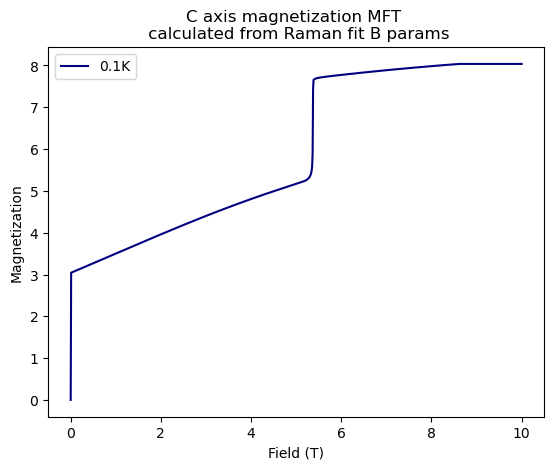

In [144]:
plt.figure()
for i in range(len(m)): 
    plt.plot(f, m[i], label = str(tempArr[i])+'K', color = colors[i])

plt.legend()
plt.title('C axis magnetization MFT \n calculated from Raman fit B params')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization')

# real quick lets do a couple temps 

In [106]:
temps = [0.1, .2, .5, .8,1,1.5]#,1.6,1.7,1.8,1.9,2]
n = len(temps)
colors = plt.cm.jet(np.linspace(0,1,n))
i = 0

dmdH = []
for mag in m: 
    temp = np.gradient(mag, f)
    dmdH.append(temp)
    # plt.plot(f, np.gradient(mft_mZ_me_C), label = str(t)+'K', color = colors[i])

# plt.legend()
# plt.xlabel(' applied field')
# plt.ylabel('dm/dH')
# # plt.xlim(0,7)
# # plt.ylim(-.1,.5)
# plt.title('C axis dM/dH \n calculated from Raman fit B params')

Text(0.5, 1.0, 'C axis dM/dH \n calculated from Raman fit B params')

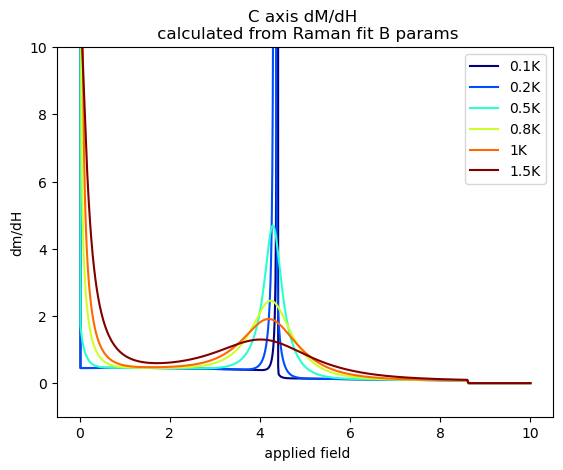

In [107]:
for i in range(len(temps)): 
    plt.plot(f, dmdH[i], label = str(temps[i])+'K', color = colors[i])

plt.legend()
plt.xlabel(' applied field')
plt.ylabel('dm/dH')
# plt.xlim(0,7)
plt.ylim(-1,10)
plt.title('C axis dM/dH \n calculated from Raman fit B params')

# now susceptibility

In [ ]:
def susceptibility(ionObj, fieldVal, temps):
    chi = []
    for temp in temps: 
        # f = newfreeEnergy(field, temp)
        # m = np.gradient(f, dx)
        f, dx = np.linspace(1-fieldVal, 1+fieldVal, 100,retstep = True) 
        field = [[0,0,b] for b in f]
        mag= np.array([ErObj.magnetization(ion, temp, f) for f in field]).T
        m = MolecularFieldTheory(f, f, mag[2], Jz)
        # m, dx, field = 1-fieldVal,1+fieldVal, temperature = temp, numpoints =100)
        m = np.array(m).T
        x = np.gradient(m, dx) 
        # now we've gotta access the very low field value
        valIdx = findIdx(field, [0,0,fieldVal])
        chi.append(x[valIdx])
        # chi.append(x)
    return chi
def findIdx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [ ]:
temps = np.linspace(0.1,300,300)
fieldVal = .1
df = 0.001
mysus = susceptibility(MyErObj, fieldVal, temps) #myErObj.susceptibility(ion, temps, field, df)
# sus = ErObj.susceptibility(ion, temps, field, df)
neutronSus = susceptibility(AllenErObj, fieldVal, temps)

In [ ]:
field = [0,0,.1]
sus = ErObj.susceptibility(ion, temps, field, df)
sus = np.array(sus).T

In [ ]:
myinv = [-1/x for x in mysus]
neutroninv = [-1/x for x in neutronSus]
# sus =  [ErObj.susceptibility(ion, t, field, df) for t in temps]
susinv = [-1/x for x in sus[2]]
plt.plot(temps, myinv, '--m', label = 'IR')
plt.plot(temps, neutroninv, '-.c', label = 'neutrons' )
plt.plot(temps, susinv, label = 'pcf susceptibility')
plt.title('calculated MFT susceptibility at 0.1T ')
plt.xlabel('temperature (K)')
plt.ylabel('1/chi')
plt.legend()
# plt.xlim(0,10)

# now we do susceptibility as a fn of field

In [ ]:
def susceptibilityConstTemp(ionObj, fields, temp):
    field = [[0,0,b] for b in fields]
    f = fields
    magMe = np.array([ionObj.magnetization(ion, temp, f)*-1 for f in field]).T
    mft_mZ_me = MolecularFieldTheory(f, f, magMe[2], lambC)
    field = np.array(field).T
    chi = np.gradient(mft_mZ_me)*-1
    return chi

In [ ]:

temps = [.01, .1, .2, .5, .8,1,1.5,1.6,1.7,1.8,1.9,2]
fields = np.linspace(-1,10,1000)
mychi = []
for t in temps: 
    x = susceptibilityConstTemp(MyErObj, fields, t)
    x = [-c for c in x]
    mychi.append(x)


In [ ]:


for i in range(len(mychi)):
    plt.plot(fields, mychi[i], label = str(temps[i])+'K')
    # plt.legend()
    plt.xlabel('field')
    plt.ylabel('chi')

plt.title('IR b params')
plt.xlim(0,10)
# plt.yscale('log')
plt.ylim(-.2,.2)


In [ ]:
temps = np.linspace(0.01,1,15)
fields = np.linspace(0,10,1000)
chi = []
for t in temps: 
    x = susceptibilityConstTemp(ErObj, fields, t)
    x = [-chi for chi in x]
    chi.append(x)

In [ ]:
for i in range(len(chi)):
    plt.plot(fields, chi[i], label = str(temps[i])+'K')
    plt.legend()
    plt.xlabel('field')
    plt.ylabel('chi')

plt.title('Neutron b params')
# plt.yscale('log')

In [ ]:
plt.plot(fields,chi[2], label= 'neutron B')
plt.plot(fields, mychi[2], label = 'IR B' )
plt.legend()
plt.yscale('log')